**Part 3. AI Agent 심화 프로젝트**

- Chapter 02. 추천시스템 Agent

    - **📒[실습]** Clip 02. 추천시스템 Agent (1)🗒️

### 사용자 메모리(State)를 활용하기

: 사용자 취향을 기반으로 추천하는 시스템


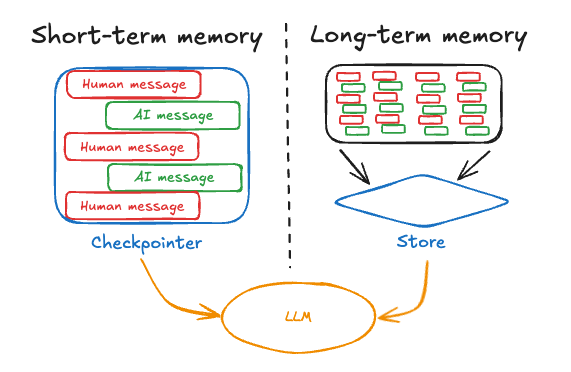

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

#### 🔧 사용자의 정보를 도구로 호출하는 법

`InjectedState` : 모델로부터 생성되지 않도록 설정

In [3]:
from typing import Annotated
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

class CustomState(AgentState):
    user_id: str

def get_user_info(
    state: Annotated[CustomState, InjectedState]
) -> str:
    """Look up user info."""
    user_id = state["user_id"]
    return "User is John Smith" if user_id == "user_123" else "Unknown user"

agent = create_react_agent(
    model=model,
    tools=[get_user_info],
    state_schema=CustomState,
)

In [4]:
response = agent.invoke({
    "messages": "look up user information",
    "user_id": "user_123"
})

In [5]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

look up user information
================================== Ai Message ==================================
Tool Calls:
  get_user_info (call_URYfq2ufj9nCt5cS7LhJkWgp)
 Call ID: call_URYfq2ufj9nCt5cS7LhJkWgp
  Args:
================================= Tool Message =================================
Name: get_user_info

User is John Smith
================================== Ai Message ==================================

The user is John Smith.


#### 1️⃣ 사용자의 기본 정보를 기반으로 추천하기 (Short Memory)

In [11]:
class InfoState(AgentState):
    user_id: str
    user_sex: str
    user_age: int

- user 기본 정보 (이름, 성별, 나이)

In [12]:
def get_user_info(
    state: Annotated[InfoState, InjectedState]
) -> str:
    """Look up user info."""
    user_id = state["user_id"]
    user_sex = state["user_sex"]
    user_age = state["user_age"]
    return "User Info: " + user_id + ", " + user_sex + ", " + str(user_age)

In [15]:
agent = create_react_agent(
    model=model,
    tools=[get_user_info],
    state_schema=InfoState,
)

response = agent.invoke({
    "messages": "사용자 기본 정보를 기반으로 영화 추천해주세요.",
    "user_id": "user_123",
    "user_sex": "female",
    "user_age": 25,
})

In [17]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

사용자 기본 정보를 기반으로 영화 추천해주세요.
================================== Ai Message ==================================
Tool Calls:
  get_user_info (call_f9ExQ5jXC1byLa7vUBsvyD9S)
 Call ID: call_f9ExQ5jXC1byLa7vUBsvyD9S
  Args:
================================= Tool Message =================================
Name: get_user_info

User Info: user_123, female, 25
================================== Ai Message ==================================

25세 여성 사용자에게 추천할 만한 영화는 다음과 같습니다:

1. **"La La Land" (2016)** - 로맨스와 아름다운 음악이 어우러진 현대 뮤지컬 영화로, 꿈을 추구하는 젊은 커플의 이야기를 그립니다.

2. **"The Great Gatsby" (2013)** - 화려한 1920년대의 뉴욕을 배경으로 사랑과 욕망, 그리고 비극적인 운명에 관한 이야기를 풀어나갑니다.

3. **"Little Women" (2019)** - 루이자 메이 올컷의 고전 소설을 바탕으로 한 영화로, 여성의 독립과 가족의 중요성을 담고 있습니다.

4. **"The Devil Wears Prada" (2006)** - 뉴욕 패션계를 배경으로 젊은 여성의 커리어와 인생에 대한 통찰을 제공하는 코미디 드라마입니다.

5. **"Pride and Prejudice" (2005)** - 제인 오스틴의 소설을 바탕으로 한 시대극 로맨스 영화로, 사랑과 사회적 계급의 문제를 다루

#### 2️⃣ 사용자의 축적된 취향을 기반으로 추천하기 (Long Memory)


In [18]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore() 

store.put(  
    ("users",),  
    "user_123",  
    {
        "user_name": "mina",
        "user_sex": "female",
        "user_age": 25,
    } 
)

In [19]:
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store

def get_user_info(config: RunnableConfig) -> str:
    """Look up user info."""
    store = get_store() 
    user_id = config["configurable"].get("user_id")
    
    user_info = store.get(("users",), user_id) 
    return str(user_info.value) if user_info else "Unknown user"


def save_user_info(
    likes: list[str] = None,
    dislikes: list[str] = None,
    current_watch: list[str] = None,
    config: RunnableConfig = None
) -> str:
    """Save user preference information to the store.
    
    Args:
        likes: List of movie titles or genres the user likes
        dislikes: List of movie titles or genres the user dislikes
        current_watch: List of movies the user has recently watched
        config: RunnableConfig with user_id
        
    When a user mentions a movie they've watched (e.g., "I recently watched La La Land"),
    add it to current_watch. When they express liking a movie or genre, add it to likes.
    When they express disliking something, add it to dislikes.
    """
    store = get_store() 
    user_id = config["configurable"].get("user_id")
    
    # Retrieve existing user data from the store
    user_info = store.get(("users",), user_id) 
    if user_info:
        user_data = user_info.value
    else:
        user_data = {}
    
    # Initialize user_data if it doesn't exist
    if likes:
        if "likes" not in user_data:
            user_data["likes"] = []
        user_data["likes"].extend(likes)
    
    if dislikes:
        if "dislikes" not in user_data:
            user_data["dislikes"] = []
        user_data["dislikes"].extend(dislikes)
    
    if current_watch:
        if "current_watch" not in user_data:
            user_data["current_watch"] = []
        user_data["current_watch"].extend(current_watch)
    
    # Save updated user data back to the store
    store.put(("users",), user_id, user_data) 
    return f"User preferences updated successfully: added {len(likes or [])} likes, {len(dislikes or [])} dislikes, and {len(current_watch or [])} watched movies."

In [20]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

agent = create_react_agent(
    model=model,
    tools=[get_user_info, save_user_info],
    store=store,
    prompt = """
        You are a helpful movie recommendation assistant that can look up user information based on a user ID.
        Use the user's preferences—such as liked and disliked genres or watch history—to recommend movies they might enjoy.
        
        Do not mention the user's personal information (e.g., age, sex, user ID) directly in your responses.

        If preference information is missing, base your recommendations on basic user information such as age and sex.
        
        IMPORTANT: Only use `save_user_info` when users EXPLICITLY state their preferences or watch history. 
        Do NOT save information when:
        - Users merely ask about a movie
        - Users ask if a movie is good or worth watching
        - Users mention a movie title as an example
        - Users are just discussing or inquiring about movies
        
        ONLY save information when:
        - Users clearly state they have watched a specific movie (e.g., "I watched La La Land recently", "나 얼마 전에 라라랜드 봤어")
        - Users express clear preference about a genre or movie (e.g., "I love action movies", "난 공포영화 싫어해")
        - Users directly share their opinions on movies they've seen (e.g., "I didn't like The Godfather", "인셉션은 정말 좋았어")
        
        Correct examples:
        - If they say "I watched La La Land recently" - call save_user_info with current_watch=["La La Land"]
        - If they say "I love action movies" - call save_user_info with likes=["action"]
        - If they say "I didn't like The Godfather" - call save_user_info with dislikes=["The Godfather"]
        
        Incorrect examples (DO NOT save these):
        - If they ask "Is Begin Again good?" - DO NOT save anything
        - If they ask "What do you think about horror movies?" - DO NOT save anything
        - If they ask "비긴 어게인 어떨까?" - DO NOT save anything
        - However, you may use the get_user_info tool to check the user's basic and preference information for assistance.
        
        If you need more details to make a better recommendation, ask warm, casual questions (e.g., "요즘 어떤 장르가 끌려요?" or "최근에 재밌게 본 영화 있어요?").
        
        Just naturally incorporate user information into your tone and movie choices.
        Keep your responses concise, helpful, and easy to understand.
        """,
    checkpointer=checkpointer,
)

In [23]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["q", "exit", "quit"]:
        break

    response = agent.invoke(
        {"messages": [{"role": "user", "content": user_input}]},
        config={"configurable": {"user_id": "user_123", "thread_id": "1"}}
    )

    for msg in response["messages"]:
        msg.pretty_print()

================================ Human Message =================================

영화 추천해줘
================================== Ai Message ==================================
Tool Calls:
  get_user_info (call_DgPpFX40MyFATK1btSrzhx8L)
 Call ID: call_DgPpFX40MyFATK1btSrzhx8L
  Args:
================================= Tool Message =================================
Name: get_user_info

{'user_name': 'mina', 'user_sex': 'female', 'user_age': 25}
================================== Ai Message ==================================

안녕하세요! 요즘 어떤 장르의 영화가 끌리시나요? 또는 최근에 재미있게 보신 영화가 있다면 알려주세요. 이에 따라 더 맞춤형 추천을 드릴 수 있을 것 같아요! 🙂
================================ Human Message =================================

최근에 라라랜드를 봤는데, 영화 추천해줘
================================== Ai Message ==================================
Tool Calls:
  save_user_info (call_pz7qQBs3cy3l2teutugnw7gO)
 Call ID: call_pz7qQBs3cy3l2teutugnw7gO
  Args:
    current_watch: ['La La Land']
================================= Tool Message ==========

In [22]:
store.get(("users",), "user_123").value

{'user_name': 'mina',
 'user_sex': 'female',
 'user_age': 25,
 'current_watch': ['La La Land'],
 'likes': ['disaster']}